In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from fastai import *
from fastai.tabular import *
from fastai.callbacks import *
from fastai.text import *
from fastai.data_block import *
from fastai.metrics import *
from sklearn.model_selection import StratifiedKFold
from swallows.training import *
from swallows.models import *
import time
from IPython.display import FileLink, FileLinks
from swallows.plots import *
from sklearn.feature_extraction.text import *

In [3]:
path=Path('data')

In [4]:
model_name = 'specialist-hw-vs-sw'
level_1_output = ''

# Data Packaging

In [5]:
df_raw = pd.read_parquet(path/'processed/training_stage_4.parquet', engine='fastparquet')
df_train = df_raw[df_raw['root_cause'].isin(['Hardware-Issue', 'Software-Issue'])].copy()

In [6]:
# df_test_raw = pd.read_parquet(path/'processed/public_test_features_stage_4.parquet', engine='fastparquet')
# df_test_preds = pd.read_csv(path/'mle_ops_tech_2019_05_04_06_40_ensemble-v4-100k.csv', low_memory=False)
# df_test = df_test_raw.merge(df_test_preds, on='ID')
# df_test = df_test[df_test['root_cause'].isin(['Hardware-Issue', 'Software-Issue'])]

In [58]:
df_train['has_offline'] = df_train['details'].str.contains('offline')

In [23]:
# splits_idxs = [s for s in gen_splits(10, df_train, 'root_cause')]
# pickle.dump(splits_idxs, open(path/f'{model_name}_cv_splits-10.pkl', "wb"))
splits_idxs = pickle.load(open(path/f'{model_name}_cv_splits-10.pkl', "rb"))
split = splits_idxs[7]

### LM

In [116]:
df_all = pd.DataFrame(df_train['details'] + ' ' +  df_train['short_description']).append(
    pd.DataFrame(df_test['details'] + ' ' +  df_test['short_description']))
          

In [117]:
# data_lm = (TextList.from_df(df_all, path=path)
#            .split_by_rand_pct(0.05)
#            .label_for_lm()
#            .databunch(bs=192)
#           )
# data_lm.save(f'data-lm-{model_name}.pkl')
# print(f'Vocabulary size {len(data_lm.vocab.itos)}')

Vocabulary size 58357


In [7]:
bs = 128 # 128 = 12502MiB (60k)
data_lm = load_data(path, f'data-lm-{model_name}.pkl', bs=bs)

In [8]:
learn_nlp = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

epoch,train_loss,valid_loss,accuracy,time
0,2.518023,2.293311,0.580575,09:27
1,2.313419,2.120568,0.601166,09:29
2,2.258076,2.073198,0.607251,09:28
3,2.218266,2.039825,0.611271,09:28
4,2.145960,2.005709,0.616217,09:28
5,2.112012,1.976681,0.620113,09:28
6,2.069845,1.961042,0.622679,09:28
7,2.076217,1.958220,0.623144,09:29


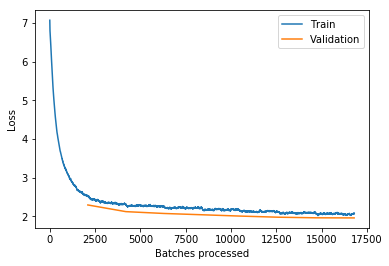

In [10]:
learn_nlp.fit_one_cycle(8, 1e-2, moms=(0.8,0.7)); learn_nlp.recorder.plot_losses()

In [11]:
learn_nlp.save(f'lm-{model_name}-1')

In [12]:
learn_nlp.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


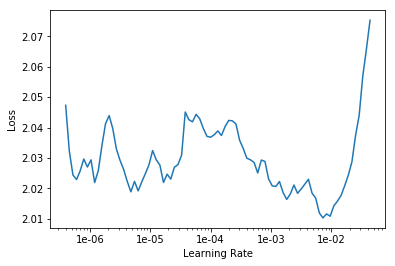

In [13]:
learn_nlp.lr_find(end_lr=1e-1); learn_nlp.recorder.plot()

In [14]:
learn_nlp.fit_one_cycle(5, 5e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.970656,1.913850,0.628602,10:36
1,1.875517,1.863964,0.635741,10:35
2,1.871585,1.838721,0.639355,10:35
3,1.870232,1.828556,0.641077,10:34
4,1.859303,1.826980,0.641287,10:35


In [15]:
learn_nlp.save(f'lm-{model_name}-tuned')

In [16]:
learn_nlp.save_encoder(f'{model_name}-tuned-enc')

In [14]:
learn_nlp.fit_one_cycle(5, 1e-5, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.842417,1.825507,0.641544,10:34
1,1.840829,1.821212,0.642273,10:35
2,1.833748,1.817685,0.642749,10:34
3,1.864089,1.816044,0.642934,10:35
4,1.843517,1.815801,0.643000,10:35


In [15]:
learn_nlp.save(f'lm-{model_name}-tuned')

In [16]:
learn_nlp.save_encoder(f'{model_name}-tuned-enc')

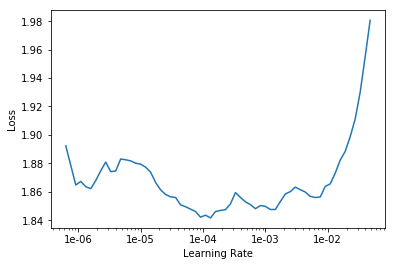

In [13]:
learn_nlp.recorder.plot(skip_end=20)

#### NLP Classifier

In [21]:
clas_text = pd.DataFrame({'text': df_train['details'] + ' ' +  df_train['short_description'], 'root_cause': df_train['root_cause']})

In [6]:
# bs=64
# data_lm = load_data(path, f'data-lm-{model_name}.pkl', bs=bs)
# data_clas = (TextList.from_df(clas_text, path, vocab=data_lm.vocab)
#              .split_by_idxs(split[0], split[1])
#              .label_from_df('root_cause')
#              .databunch(bs=bs))
# data_clas.save(f'data_clas_{model_name}.pkl')
data_clas = load_data(path, f'data_clas_{model_name}.pkl')

In [25]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)
learn.load_encoder(f'{model_name}-tuned-enc')

epoch,train_loss,valid_loss,accuracy,time
0,0.538497,0.480920,0.776280,02:36


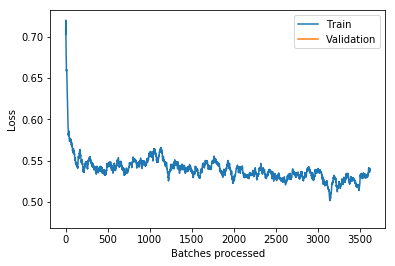

In [26]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7)); learn.recorder.plot_losses()

In [28]:
learn.save(f'{model_name}-nlp-1')

epoch,train_loss,valid_loss,accuracy,time
0,0.512081,0.477063,0.779116,03:00


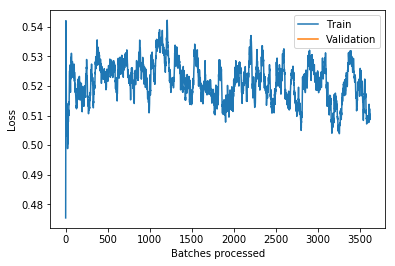

In [29]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-4/(2.6**4),1e-4), moms=(0.8, 0.7)); learn.recorder.plot_losses()

epoch,train_loss,valid_loss,accuracy,time
0,0.490323,0.455898,0.790269,04:36


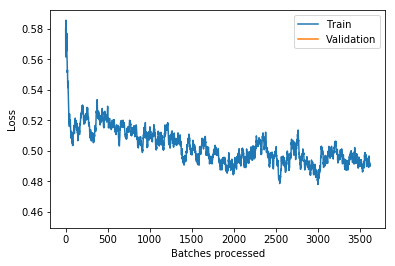

In [32]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(1e-3/(2.6**4),1e-3), moms=(0.8, 0.7)); learn.recorder.plot_losses()

In [33]:
learn.save(f'{model_name}-nlp-2')

epoch,train_loss,valid_loss,accuracy,time
0,0.474778,0.455101,0.791241,06:20
1,0.480546,0.454668,0.790969,06:49
2,0.484284,0.454310,0.791513,06:39


Better model found at epoch 0 with accuracy value: 0.7912408113479614.
Better model found at epoch 2 with accuracy value: 0.7915128469467163.


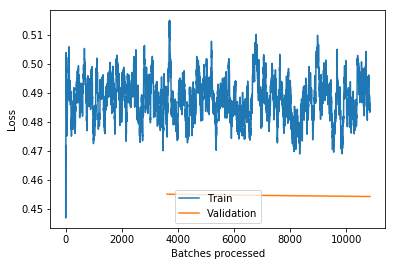

In [48]:
learn.unfreeze()
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy', name=f'{model_name}-nlp-final')
learn.fit_one_cycle(3, slice(1e-5/(2.6**4),1e-5), moms=(0.8, 0.7), callbacks=callbacks); learn.recorder.plot_losses()

In [49]:
learn.load(f'{model_name}-nlp-final')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (231607 items)
x: TextList
xxbos xxwfssworkflow xxup it support , xxmaj problem xxmaj location : xxup icqa desk xxmaj device xxup os : xxmaj windows xxmaj problem xxmaj description : java updates need admin password xxmaj please assist xxmaj asset xxmaj number : . . xxunk help xxmaj software xxmaj installation xxmaj request,xxbos xxwfssworkflow xxup it support , xxmaj device xxmaj model / xxmaj brand : xxup hp xxmaj mobile xxmaj cart xxup ib 6 ( # 21 ) xxmaj device xxmaj location : 3rd floor red tag area xxmaj problem xxmaj description : xxmaj printmon not downloaded on xxunk xxmaj computer ca n't connect to internet . . ethadodd help xxmaj mobile xxmaj cart,xxbos xxmaj workflow name : xxmaj screen or xxmaj monitor xxmaj issue warehouseid : xxup las2 xxmaj device xxmaj name / xxmaj workstation xxmaj location : xxup crets station 4 - 26 xxmaj problem xxmaj description : xxmaj keyboard not working properly . i help xxmaj screen or xxma

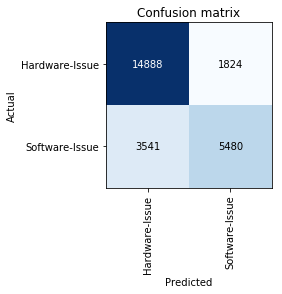

In [50]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

## Tabular

In [51]:
cont_names = [] # [f'tok_{i}' for i in range(n_tok)]  #['create_to_assigned_lag_log']
exclude_from_cats = [
    'ID', 
    'assigned_date',
    'create_date',
    'details',
    'short_description',
    'amazon_domains',
    'root_cause',
    'create_to_assigned_lag'
    'create_to_assigned_lag_log',
    'assigned_date_Elapsed'
    'create_date_Elapsed',
    'details_tok'
] + cont_names

cat_names = [c for c in df_train.columns if c not in exclude_from_cats]
dep_var = 'root_cause'
procs = [FillMissing, Categorify, Normalize]

In [9]:
bs=1024
# # test = TabularList.from_df(df_test[cat_names + cont_names], path=path, cat_names=cat_names, cont_names=cont_names)
# data_tab = (TabularList.from_df(df_train,
#                             path=path, cat_names=cat_names, cont_names=cont_names, procs=procs)
#                            .split_by_idxs(split[0], split[1])
#                            .label_from_df(cols=dep_var)
# #                            .add_test(test)
#                            .databunch(bs=bs))
# data_tab.save(f'data_tab_{model_name}.pkl')

data_tab = load_data(path, f'data_tab_{model_name}.pkl', bs=bs)

# Training

In [56]:
learn = tabular_learner(data_tab, layers=[727,353], ps=0.5, emb_drop=0.5, metrics=accuracy)

epoch,train_loss,valid_loss,accuracy,time
0,0.533824,0.520335,0.743365,00:25
1,0.523916,0.515337,0.750903,00:25
2,0.520426,0.507980,0.752963,00:25
3,0.510619,0.503512,0.755878,00:25
4,0.505425,0.500510,0.757160,00:25
5,0.495840,0.495384,0.760386,00:25
6,0.489939,0.493662,0.761163,00:25
7,0.480586,0.492784,0.762057,00:25
8,0.476723,0.493890,0.762523,00:25


Better model found at epoch 0 with accuracy value: 0.7433645725250244.
Better model found at epoch 1 with accuracy value: 0.7509034872055054.
Better model found at epoch 2 with accuracy value: 0.752963125705719.
Better model found at epoch 3 with accuracy value: 0.755877673625946.
Better model found at epoch 4 with accuracy value: 0.7571600675582886.
Better model found at epoch 5 with accuracy value: 0.7603855133056641.
Better model found at epoch 6 with accuracy value: 0.7611626982688904.
Better model found at epoch 7 with accuracy value: 0.7620565295219421.
Better model found at epoch 8 with accuracy value: 0.76252281665802.


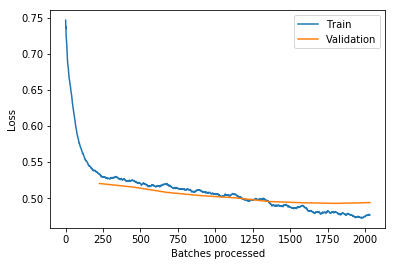

In [57]:
callbacks = SaveModelCallback(learn, every='improvement', mode='max', monitor='accuracy', name=f'{model_name}-tab-final')
learn.fit_one_cycle(9, 1e-2, callbacks=callbacks); learn.recorder.plot_losses()

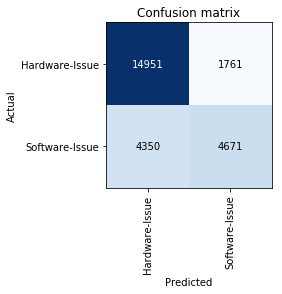

In [59]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()